In [1]:
import numpy as np
import os
from glob import glob
import scipy.io as sio
from skimage.io import imread, imsave
from skimage.transform import rescale, resize
from skimage.transform import estimate_transform, warp
from time import time
import argparse
import ast
import matplotlib.pyplot as plt
import argparse

from api import PRN
from utils.render import render_texture
import cv2

In [2]:
# parameter inlitialization
image_path = 'TestImages/AFLW2000/image00081.jpg'
ref_path = 'TestImages/trump.jpg'
name = 'output_render'
output_path = 'TestImages/output.jpg'
mode = 1
gpu = '0'
dlib = True

# ---- Options for CPU and GPU
os.environ['CUDA_VISIBLE_DEVICES'] = gpu # GPU number, -1 for CPU
#prn = PRN(is_dlib = True) 

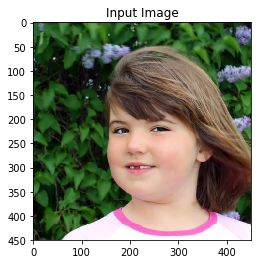

(450, 450, 3)


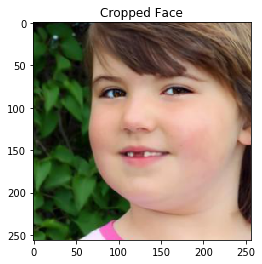

(256, 256, 3)


In [3]:
# read image
resolution_inp = 256
resolution_op = 256
prefix = '.'
image = imread(image_path)
[h, w, _] = image.shape
plt.imshow(image)
plt.title('Input Image')
plt.show()
print(image.shape)

#-- 1. 3d reconstruction -> get texture. 
import dlib
detector_path = os.path.join(prefix, 'Data/net-data/mmod_human_face_detector.dat')
face_detector = dlib.cnn_face_detection_model_v1(detector_path)
detected_faces = face_detector(image, 1)

if len(detected_faces) == 0:
    print('warning: no detected face')
    
d = detected_faces[0].rect ## only use the first detected face (assume that each input image only contains one face)
left = d.left(); right = d.right(); top = d.top(); bottom = d.bottom()
old_size = (right - left + bottom - top)/2
center = np.array([right - (right - left) / 2.0, bottom - (bottom - top) / 2.0 + old_size*0.14])
size = int(old_size*1.58)

# crop image and resize it to predefined resolution
src_pts = np.array([[center[0]-size/2, center[1]-size/2], [center[0] - size/2, center[1]+size/2], [center[0]+size/2, center[1]-size/2]])
DST_PTS = np.array([[0,0], [0, resolution_inp - 1], [resolution_inp - 1, 0]])
tform = estimate_transform('similarity', src_pts, DST_PTS)

image = image/255.
cropped_image = warp(image, tform.inverse, output_shape=(resolution_inp, resolution_inp))
plt.imshow(cropped_image)
plt.title('Cropped Face')
plt.show()
print(cropped_image.shape)

In [4]:
# The Architecture of Position map Regression Network
import tensorflow as tf
import tensorflow.contrib.layers as tcl
from tensorflow.contrib.framework import arg_scope
import numpy as np
import os

def resBlock(x, num_outputs, kernel_size = 4, stride=1, activation_fn=tf.nn.relu, normalizer_fn=tcl.batch_norm, scope=None):
    assert num_outputs%2==0 #num_outputs must be divided by channel_factor(2 here)
    with tf.variable_scope(scope, 'resBlock'):
        shortcut = x
        if stride != 1 or x.get_shape()[3] != num_outputs:
            shortcut = tcl.conv2d(shortcut, num_outputs, kernel_size=1, stride=stride, 
                        activation_fn=None, normalizer_fn=None, scope='shortcut')
        x = tcl.conv2d(x, num_outputs/2, kernel_size=1, stride=1, padding='SAME')
        x = tcl.conv2d(x, num_outputs/2, kernel_size=kernel_size, stride=stride, padding='SAME')
        x = tcl.conv2d(x, num_outputs, kernel_size=1, stride=1, activation_fn=None, padding='SAME', normalizer_fn=None)

        x += shortcut       
        x = normalizer_fn(x)
        x = activation_fn(x)
    return x


class resfcn256(object):
    def __init__(self, resolution_inp = 256, resolution_op = 256, channel = 3, name = 'resfcn256'):
        self.name = name
        self.channel = channel
        self.resolution_inp = resolution_inp
        self.resolution_op = resolution_op

    def __call__(self, x, is_training = True):
        with tf.variable_scope(self.name) as scope:
            with arg_scope([tcl.batch_norm], is_training=is_training, scale=True):
                with arg_scope([tcl.conv2d, tcl.conv2d_transpose], activation_fn=tf.nn.relu, 
                                     normalizer_fn=tcl.batch_norm, 
                                     biases_initializer=None, 
                                     padding='SAME',
                                     weights_regularizer=tcl.l2_regularizer(0.0002)):
                    size = 16  
                    # x: s x s x 3
                    se = tcl.conv2d(x, num_outputs=size, kernel_size=4, stride=1) # 256 x 256 x 16
                    se = resBlock(se, num_outputs=size * 2, kernel_size=4, stride=2) # 128 x 128 x 32
                    se = resBlock(se, num_outputs=size * 2, kernel_size=4, stride=1) # 128 x 128 x 32
                    se = resBlock(se, num_outputs=size * 4, kernel_size=4, stride=2) # 64 x 64 x 64
                    se = resBlock(se, num_outputs=size * 4, kernel_size=4, stride=1) # 64 x 64 x 64
                    se = resBlock(se, num_outputs=size * 8, kernel_size=4, stride=2) # 32 x 32 x 128
                    se = resBlock(se, num_outputs=size * 8, kernel_size=4, stride=1) # 32 x 32 x 128
                    se = resBlock(se, num_outputs=size * 16, kernel_size=4, stride=2) # 16 x 16 x 256
                    se = resBlock(se, num_outputs=size * 16, kernel_size=4, stride=1) # 16 x 16 x 256
                    se = resBlock(se, num_outputs=size * 32, kernel_size=4, stride=2) # 8 x 8 x 512
                    se = resBlock(se, num_outputs=size * 32, kernel_size=4, stride=1) # 8 x 8 x 512

                    pd = tcl.conv2d_transpose(se, size * 32, 4, stride=1) # 8 x 8 x 512 
                    pd = tcl.conv2d_transpose(pd, size * 16, 4, stride=2) # 16 x 16 x 256 
                    pd = tcl.conv2d_transpose(pd, size * 16, 4, stride=1) # 16 x 16 x 256 
                    pd = tcl.conv2d_transpose(pd, size * 16, 4, stride=1) # 16 x 16 x 256 
                    pd = tcl.conv2d_transpose(pd, size * 8, 4, stride=2) # 32 x 32 x 128 
                    pd = tcl.conv2d_transpose(pd, size * 8, 4, stride=1) # 32 x 32 x 128 
                    pd = tcl.conv2d_transpose(pd, size * 8, 4, stride=1) # 32 x 32 x 128 
                    pd = tcl.conv2d_transpose(pd, size * 4, 4, stride=2) # 64 x 64 x 64 
                    pd = tcl.conv2d_transpose(pd, size * 4, 4, stride=1) # 64 x 64 x 64 
                    pd = tcl.conv2d_transpose(pd, size * 4, 4, stride=1) # 64 x 64 x 64 
                    
                    pd = tcl.conv2d_transpose(pd, size * 2, 4, stride=2) # 128 x 128 x 32
                    pd = tcl.conv2d_transpose(pd, size * 2, 4, stride=1) # 128 x 128 x 32
                    pd = tcl.conv2d_transpose(pd, size, 4, stride=2) # 256 x 256 x 16
                    pd = tcl.conv2d_transpose(pd, size, 4, stride=1) # 256 x 256 x 16

                    pd = tcl.conv2d_transpose(pd, 3, 4, stride=1) # 256 x 256 x 3
                    pd = tcl.conv2d_transpose(pd, 3, 4, stride=1) # 256 x 256 x 3
                    pos = tcl.conv2d_transpose(pd, 3, 4, stride=1, activation_fn = tf.nn.sigmoid)#, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
                                
                    return pos
    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

# load PRN trained model first
prefix = '.'
prn_path = os.path.join(prefix, 'Data/net-data/256_256_resfcn256_weight')
if not os.path.isfile(prn_path + '.data-00000-of-00001'):
    print("please download PRN trained model first.")
    exit()

# -- hyper settings
resolution_inp = 256
resolution_op = 256
MaxPos = resolution_inp*1.1

# network type
network = resfcn256(resolution_inp, resolution_op)

#tensflow initialization
x = tf.placeholder(tf.float32, shape=[None, resolution_inp, resolution_inp, 3])  
x_op = network(x, is_training = False)
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
tf.train.Saver(network.vars).restore(sess, prn_path) 

pos = sess.run(x_op, feed_dict = {x: cropped_image[np.newaxis, :,:,:]})
pos = np.squeeze(pos)
cropped_pos = pos*MaxPos
#print(cropped_pos)


# restore all_vertices of cropped face
cropped_vertices = np.reshape(cropped_pos, [-1, 3]).T
z = cropped_vertices[2,:].copy()/tform.params[0,0]
cropped_vertices[2,:] = 1
vertices = np.dot(np.linalg.inv(tform.params), cropped_vertices)
vertices = np.vstack((vertices[:2,:], z))
pos = np.reshape(vertices.T, [resolution_op, resolution_op, 3])
# print(pos)

INFO:tensorflow:Restoring parameters from ./Data/net-data/256_256_resfcn256_weight


In [5]:
# Get 3D vertices
import numpy as np
import os
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp
from time import time
import ast

from api import PRN

from utils.estimate_pose import estimate_pose
from utils.rotate_vertices import frontalize
from utils.render_app import get_visibility, get_uv_mask, get_depth_image
from utils.write import write_obj_with_colors, write_obj_with_texture

# uv file
uv_kpt_ind = np.loadtxt(prefix + '/Data/uv-data/uv_kpt_ind.txt').astype(np.int32) # 2 x 68 get kpt
face_ind = np.loadtxt(prefix + '/Data/uv-data/face_ind.txt').astype(np.int32) # get valid vertices in the pos map
triangles = np.loadtxt(prefix + '/Data/uv-data/triangles.txt').astype(np.int32) # ntri x 3

#get vertices
'''
get_vertices(self, pos):
Args:
    pos: the 3D position map. shape = (256, 256, 3).
Returns:
    vertices: the vertices(point cloud). shape = (num of points, 3). n is about 40K here.
'''
all_vertices = np.reshape(pos, [resolution_op**2, -1])
vertices = all_vertices[face_ind, :]

# print(vertices.shape)

# Get texture
image = image/255.
texture = cv2.remap(image, pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, 
                    borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

# 코드를 컴파일 하고 나서 restart 해야 합니다!!!

In [1]:
## !!!!! In order to run this cell, you need to restart the kernel and then run it
#-- 2. Texture Editing. 
import numpy as np
import os
from glob import glob
import scipy.io as sio
from skimage.io import imread, imsave
from skimage.transform import rescale, resize
from time import time
import argparse
import ast
import matplotlib
import matplotlib.pyplot as plt
import argparse

from api import PRN
from utils.render import render_texture
import cv2

image_path = 'TestImages/AFLW2000/image00081.jpg'
# ref_path = 'TestImages/trump.jpg'
ref_path = 'TestImages/5.jpg'
name = 'output_render'
output_path = 'TestImages/output.jpg'
gpu = '0'
dlib = True
prn = PRN(is_dlib = True) 
Mode = 0

image = imread(image_path)
[h, w, _] = image.shape

#-- 1. 3d reconstruction -> get texture. 
pos = prn.process(image) 
vertices = prn.get_vertices(pos)
image = image/255.
texture = cv2.remap(image, pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
# print(texture)

if Mode == 0: 
    # load eye mask
    uv_face_eye = imread('Data/uv-data/uv_face_eyes.png', as_grey=True)/255. 
    uv_face = imread('Data/uv-data/uv_face.png', as_grey=True)/255.
    eye_mask = (abs(uv_face_eye - uv_face) > 0).astype(np.float32)

    # texture from another image or a processed texture
    ref_image = imread(ref_path)
    ref_pos = prn.process(ref_image)
    ref_image = ref_image/255.
    ref_texture = cv2.remap(ref_image, ref_pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

    # modify texture
    new_texture = texture*(1 - eye_mask[:,:,np.newaxis]) + ref_texture*eye_mask[:,:,np.newaxis]

# change whole face(face swap)
elif Mode == 1: 
    # texture from another image or a processed texture
    ref_image = imread(ref_path)
    ref_pos = prn.process(ref_image)
    ref_image = ref_image/255.
    ref_texture = cv2.remap(ref_image, ref_pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    ref_vertices = prn.get_vertices(ref_pos)
    new_texture = ref_texture#(texture + ref_texture)/2.

# change part of texture(for data augumentation/selfie editing. Here modify mouse for example)
elif Mode == 2: 
    # load eye mask
    uv_face_mouse = imread('Data/uv-data/uv_face_mouse.png', as_grey=True)/255. 
    uv_face = imread('Data/uv-data/uv_face.png', as_grey=True)/255.
    mouse_mask = (abs(uv_face_mouse - uv_face) > 0).astype(np.float32)

    # texture from another image or a processed texture
    ref_image = imread(ref_path)
    ref_pos = prn.process(ref_image)
    ref_image = ref_image/255.
    ref_texture = cv2.remap(ref_image, ref_pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

    # modify texture
    new_texture = texture*(1 - mouse_mask[:,:,np.newaxis]) + ref_texture*mouse_mask[:,:,np.newaxis]

else:
    print('Wrong Mode! Mode should be 0 or 1.')
    exit()

    
#-- 3. remap to input image.(render)
vis_colors = np.ones((vertices.shape[0], 1))
face_mask = render_texture(vertices.T, vis_colors.T, prn.triangles.T, h, w, c = 1)
face_mask = np.squeeze(face_mask > 0).astype(np.float32)

new_colors = prn.get_colors_from_texture(new_texture)
new_image = render_texture(vertices.T, new_colors.T, prn.triangles.T, h, w, c = 3)
new_image = image*(1 - face_mask[:,:,np.newaxis]) + new_image*face_mask[:,:,np.newaxis]

# plt.imshow(new_image)
# plt.title('Reference Image')
# plt.show()

# Possion Editing for blending image
vis_ind = np.argwhere(face_mask>0)
vis_min = np.min(vis_ind, 0)
vis_max = np.max(vis_ind, 0)
center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
output = cv2.seamlessClone((new_image*255).astype(np.uint8), (image*255).astype(np.uint8), (face_mask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

# save output
imsave(output_path, output) 
image_path = 'TestImages/output.jpg'
outout_image = imread(image_path)
print(output.shape)
plt.imshow(outout_image)
plt.title('Rendered Image')
plt.show()

print('Done.')

INFO:tensorflow:Restoring parameters from ./Data/net-data/256_256_resfcn256_weight


/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


(450, 450, 3)


<Figure size 640x480 with 1 Axes>

Done.
